In [2]:
!unzip "Twitter US Airline Sentiment.zip"

Archive:  Twitter US Airline Sentiment.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  database.sqlite   sample_data	 Tweets.csv  'Twitter US Airline Sentiment.zip'


In [3]:
!ls

 database.sqlite   sample_data	 Tweets.csv  'Twitter US Airline Sentiment.zip'


In [5]:
import pandas as pd

df = pd.read_csv("Tweets.csv")

print("Shape:", df.shape)
display(df.head(3))
print(df.columns.tolist())

Shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [8]:
print(df["airline_sentiment"].value_counts(dropna=False))

print("Missing text:", df["text"].isna().sum())
print("Missing sentiment:", df["airline_sentiment"].isna().sum())

display(df[["airline_sentiment", "text"]].sample(5))

df = df[["airline_sentiment", "text"]].dropna().reset_index(drop=True)

print("Cleaned shape:", df.shape)
print(df["airline_sentiment"].value_counts())
display(df.head(3))


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64
Missing text: 0
Missing sentiment: 0


,airline_sentiment,text
11850,negative,@USAirways I expect something more than tellin...
2821,neutral,@united this is for a check-in luggage. Employ...
14374,positive,@AmericanAir RDU Customer Service is awesome. ...
11616,positive,@USAirways glad to be home and that your grea...
6702,negative,"@SouthwestAir Flight Cancelled Flightled, reFl..."


Cleaned shape: (14640, 2)
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...


In [11]:
label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

df["label"] = df["airline_sentiment"].map(label_map)

print(df[["airline_sentiment", "label"]].head())
print(df["label"].value_counts())

from sklearn.model_selection import train_test_split

X = df["text"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))

import numpy as np

print("Train distribution:", np.bincount(y_train))
print("Val distribution:", np.bincount(y_val))
print("Test distribution:", np.bincount(y_test))

  airline_sentiment  label
0           neutral      1
1          positive      2
2           neutral      1
3          negative      0
4          negative      0
label
0    9178
1    3099
2    2363
Name: count, dtype: int64
Train: 10248
Validation: 2196
Test: 2196
Train distribution: [6425 2169 1654]
Val distribution: [1376  465  355]
Test distribution: [1377  465  354]


In [13]:
from collections import Counter
import re

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

tokenized_train = [tokenize(t) for t in X_train]

counter = Counter()
for tokens in tokenized_train:
    counter.update(tokens)

vocab_size = 10000

vocab = {
    "<PAD>": 0,
    "<UNK>": 1
}

for i, (word, _) in enumerate(counter.most_common(vocab_size - 2), start=2):
    vocab[word] = i

print("Vocabulary size:", len(vocab))

def encode(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

X_train_seq = [encode(t, vocab) for t in X_train]
X_val_seq = [encode(t, vocab) for t in X_val]
X_test_seq = [encode(t, vocab) for t in X_test]

print(X_train_seq[0][:20])

Vocabulary size: 10000
[17, 1316, 255, 198, 5371, 127, 223, 62, 54, 35, 11, 66, 540, 208, 40, 10, 824, 149, 2, 38]


In [15]:
import torch

max_len = 50

def pad_sequence(seq, max_len):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [0] * (max_len - len(seq))

X_train_pad = torch.tensor([pad_sequence(seq, max_len) for seq in X_train_seq])
X_val_pad = torch.tensor([pad_sequence(seq, max_len) for seq in X_val_seq])
X_test_pad = torch.tensor([pad_sequence(seq, max_len) for seq in X_test_seq])

y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

print(X_train_pad.shape)
print(y_train_t.shape)

from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_ds = TensorDataset(X_train_pad, y_train_t)
val_ds = TensorDataset(X_val_pad, y_val_t)
test_ds = TensorDataset(X_test_pad, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


torch.Size([10248, 50])
torch.Size([10248])


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)
        out = self.fc(hidden.squeeze(0))
        return out

embed_dim = 100
hidden_dim = 128
output_dim = 3
learning_rate = 0.001

model = SentimentRNN(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

epochs = 5

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )
test_loss, test_acc = eval_epoch(model, test_loader)
print(f"Test Accuracy (Iteration 1): {test_acc:.4f}")


Epoch 1/5 | Train Loss: 0.9254 | Val Loss: 0.9189 | Val Acc: 0.6266
Epoch 2/5 | Train Loss: 0.9160 | Val Loss: 0.9234 | Val Acc: 0.6266
Epoch 3/5 | Train Loss: 0.9222 | Val Loss: 0.9186 | Val Acc: 0.6266
Epoch 4/5 | Train Loss: 0.9160 | Val Loss: 0.9194 | Val Acc: 0.6266
Epoch 5/5 | Train Loss: 0.9191 | Val Loss: 0.9188 | Val Acc: 0.6266
Test Accuracy (Iteration 1): 0.6270


Pred shape: (2196,)
True shape: (2196,)
              precision    recall  f1-score   support

    negative     0.6270    1.0000    0.7708      1377
     neutral     0.0000    0.0000    0.0000       465
    positive     0.0000    0.0000    0.0000       354

    accuracy                         0.6270      2196
   macro avg     0.2090    0.3333    0.2569      2196
weighted avg     0.3932    0.6270    0.4833      2196



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


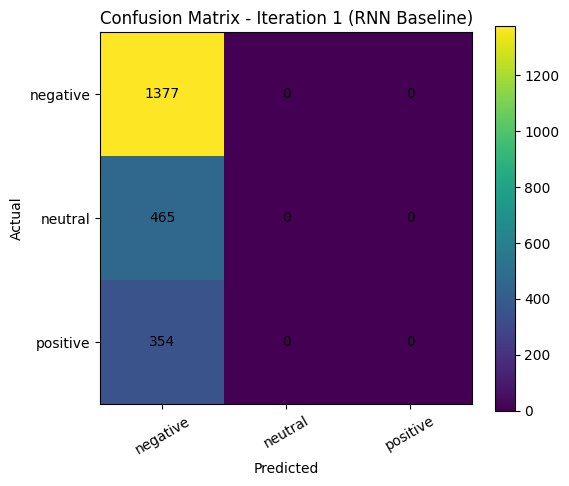

Total misclassified: 819
TRUE: positive | PRED: negative
TEXT: @JetBlue would you say a delay is more likely? Thanks so much.
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: @united can you help me add my KTN to this reservation PLZ?
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: Really ? 😑“@JetBlue: Our fleet's on fleek. http://t.co/V5QWkYXSW6”
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: @AmericanAir thanks!
--------------------------------------------------------------------------------
TRUE: positive | PRED: negative
TEXT: @United Global First Class Lounge ORD menu. Yummy! http://t.co/egKvFoKogj
--------------------------------------------------------------------------------
TRUE: neutral | PRED: negative
TEXT: @united I see several economy plus can you put us in those. W

In [28]:
import numpy as np
import torch

model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model(Xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

print("Pred shape:", all_preds.shape)
print("True shape:", all_true.shape)
from sklearn.metrics import classification_report

target_names = ["negative", "neutral", "positive"]

print(classification_report(all_true, all_preds, target_names=target_names, digits=4))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true, all_preds)
cm

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.xticks(range(3), target_names, rotation=30)
plt.yticks(range(3), target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Iteration 1 (RNN Baseline)")
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

label_rev = {0:"negative", 1:"neutral", 2:"positive"}

mis_idx = np.where(all_preds != all_true)[0]
print("Total misclassified:", len(mis_idx))

show_n = 8
for k in mis_idx[:show_n]:
    print("TRUE:", label_rev[all_true[k]], "| PRED:", label_rev[all_preds[k]])
    print("TEXT:", X_test[k])
    print("-"*80)

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1,2]),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

embed_dim = 100
hidden_dim = 128
dropout = 0.5
learning_rate = 0.001

model2 = SentimentGRU(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    output_dim=3,
    dropout=dropout
).to(device)

criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

model2

epochs = 6

for epoch in range(epochs):
    model2.train()
    total_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer2.zero_grad()
        outputs = model2(Xb)
        loss = criterion2(outputs, yb)
        loss.backward()
        optimizer2.step()

        total_loss += loss.item()

    val_loss, val_acc = eval_epoch(model2, val_loader)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {total_loss/len(train_loader):.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1/6 | Train Loss: 1.1005 | Val Loss: 1.1056 | Val Acc: 0.1621
Epoch 2/6 | Train Loss: 0.9630 | Val Loss: 0.8268 | Val Acc: 0.6134
Epoch 3/6 | Train Loss: 0.7755 | Val Loss: 0.7911 | Val Acc: 0.6444
Epoch 4/6 | Train Loss: 0.6365 | Val Loss: 0.6925 | Val Acc: 0.7145
Epoch 5/6 | Train Loss: 0.5263 | Val Loss: 0.7271 | Val Acc: 0.7077
Epoch 6/6 | Train Loss: 0.4208 | Val Loss: 0.6711 | Val Acc: 0.7404


Test Accuracy (Iteration 2): 0.7505
(2196,) (2196,)
              precision    recall  f1-score   support

    negative     0.8873    0.8003    0.8415      1377
     neutral     0.4961    0.6817    0.5743       465
    positive     0.7270    0.6469    0.6846       354

    accuracy                         0.7505      2196
   macro avg     0.7035    0.7096    0.7001      2196
weighted avg     0.7786    0.7505    0.7597      2196



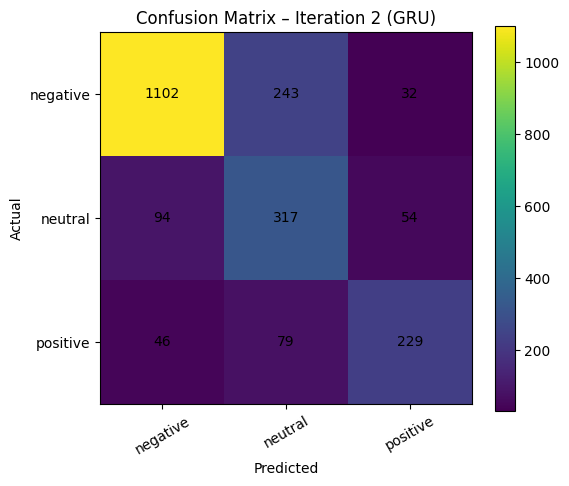

Total misclassified (Iter 2): 548
TRUE: negative | PRED: neutral
TEXT: @AmericanAir ok. Pilots are looking for agents  - they jumped out / FLT 5350 #DFW / this is crazy
--------------------------------------------------------------------------------
TRUE: positive | PRED: neutral
TEXT: @JetBlue would you say a delay is more likely? Thanks so much.
--------------------------------------------------------------------------------
TRUE: neutral | PRED: positive
TEXT: @AmericanAir thanks!
--------------------------------------------------------------------------------
TRUE: neutral | PRED: positive
TEXT: @united that's what I thought! Thanks for the clarification!
--------------------------------------------------------------------------------
TRUE: negative | PRED: neutral
TEXT: @united I'm on UA1118 and my direct tv isn't working.  How do I avoid this in future?
--------------------------------------------------------------------------------
TRUE: negative | PRED: neutral
TEXT: @united GR

In [42]:
test_loss2, Attach_acc2 = eval_epoch(model2, test_loader)
print(f"Test Accuracy (Iteration 2): {Attach_acc2:.4f}")
model2.eval()

all_preds2 = []
all_true2 = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model2(Xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds2.extend(preds)
        all_true2.extend(yb.numpy())

all_preds2 = np.array(all_preds2)
all_true2 = np.array(all_true2)

print(all_preds2.shape, all_true2.shape)

from sklearn.metrics import classification_report

print(
    classification_report(
        all_true2,
        all_preds2,
        target_names=["negative", "neutral", "positive"],
        digits=4
    )
)

from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(all_true2, all_preds2)
cm2

plt.figure(figsize=(6,5))
plt.imshow(cm2)
plt.xticks(range(3), ["negative", "neutral", "positive"], rotation=30)
plt.yticks(range(3), ["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Iteration 2 (GRU)")
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm2[i, j], ha="center", va="center")

plt.show()

mis_idx2 = np.where(all_preds2 != all_true2)[0]
print("Total misclassified (Iter 2):", len(mis_idx2))

for k in mis_idx2[:6]:
    print("TRUE:", label_rev[all_true2[k]], "| PRED:", label_rev[all_preds2[k]])
    print("TEXT:", X_test[k])
    print("-"*80)